In [1]:
import rebound
import numpy as np
import pandas as pd
import systems.sys_params as sysp

In [2]:
nomass_sys, vaneye_sys, danjh_sys = sysp.get_system_lists()

In [64]:
system = vaneye_sys[3]
print("Analyzing System %s"%system)

# get periods, determine proper ordering (not ordered by default!)
P1 = float(open("systems/data_files/van_eylen/%s/period_%s.01.txt"%(system, system), 'r').readlines()[1].split()[0])
P2 = float(open("systems/data_files/van_eylen/%s/period_%s.02.txt"%(system, system), 'r').readlines()[1].split()[0])
P3 = float(open("systems/data_files/van_eylen/%s/period_%s.03.txt"%(system, system), 'r').readlines()[1].split()[0])
sort_index = [x for _,x in sorted(zip([P1, P2, P3],["1","2","3"]))]
orb_params = []
for index in sort_index:
    orb_params += ["T%s"%index,"b%s"%index,"e%s"%index,"w%s"%index,"r%s/rs"%index,"Fs%s"%index]
orb_params += ["gam1","gam2"]

samples = np.load("systems/data_files/van_eylen/%s/chain_period_eccentricity_finalone.dat.npy"%system)
data = pd.DataFrame(samples.reshape(-1, samples.shape[2]), columns=orb_params)

# absolute value. Vincent used negatives to keep track of longer/shorter transits due to angles
for c in ["e1","e2","e3"]:
    data[c] = data[c].abs()
    
# adding period to each column
data["P%s"%sort_index[0]] = P1
data["P%s"%sort_index[1]] = P2
data["P%s"%sort_index[2]] = P3

Analyzing System K00285


So... when you get it working though, I *think* the task is for you to calculate Mean anomaly at mid-transit:
$$
E_{@mid-transit} = 2*atan(sqrt(1-e/(1+e)))*tan(1/2*(pi/2-omega))  \\
M_{@mid-transit} = E - e*sin(omega)
$$

And then wind the clock back so that they are all consistent for a single time, i.e. for the smallest mid-transit time. So assuming (for simplicity for now) that $T1$ is always smallest:
$$
M_{2, @mid-transit-of-planet-1} = M_{2, @mid-transit} - n_2(T_2 - T_1) \\
M_{3, @mid-transit-of-planet-1} = M_{3, @mid-transit} - n_3(T_3 - T_1)
$$

In [82]:
min_transit_times = np.min(np.array((data["T1"],data["T2"],data["T3"])), axis=0)
M_buffer = 0.025 # extra offset so that they cross in rebound at pi/2 - omega

for i in ["1","2","3"]:
    e, w, n = data["e%s"%i], data["w%s"%i], 2*np.pi/data["P%s"%i]
    E_midtr = 2*np.arctan(np.sqrt((1-e)/(1+e))*np.tan((np.pi/2 - w)/2))
    M_midtr = E_midtr - e*np.sin(E_midtr)
    data["M%s"%i] = M_midtr + n*(min_transit_times - data["T%s"%i] - M_buffer)  

In [83]:
data.head()

,T1,b1,e1,w1,r1/rs,Fs1,T2,b2,e2,w2,...,r3/rs,Fs3,gam1,gam2,P1,P2,P3,M1,M2,M3
0,0.000169,0.019592,0.382741,0.304394,0.018909,0.999998,-0.005214,-0.150612,0.091611,0.158469,...,0.011676,0.999996,0.392243,0.128234,13.748933,26.723115,49.356754,0.591091,1.225486,1.762360
1,0.000169,0.019592,0.382741,0.304394,0.018909,0.999998,-0.005214,-0.150612,0.091611,0.158469,...,0.011676,0.999996,0.392243,0.128234,13.748933,26.723115,49.356754,0.591091,1.225486,1.762360
2,0.000169,0.019592,0.382741,0.304394,0.018909,0.999998,-0.005214,-0.150612,0.091611,0.158469,...,0.011676,0.999996,0.392243,0.128234,13.748933,26.723115,49.356754,0.591091,1.225486,1.762360
3,0.000168,0.024516,0.384129,0.308766,0.018901,0.999998,-0.005200,-0.154177,0.092544,0.160706,...,0.011680,0.999996,0.392485,0.127772,13.748933,26.723115,49.356754,0.586224,1.221531,1.760041
4,0.000251,0.041104,0.374515,0.309311,0.018903,0.999998,-0.005564,-0.158965,0.097263,0.142460,...,0.011650,0.999996,0.391025,0.137135,13.748933,26.723115,49.356754,0.600141,1.229964,1.819499


In [84]:
import forecaster.mr_forecast as mr
def construct_sim(sim, data, system, i=0):
    Ms = float(open("systems/data_files/van_eylen/%s/stellar_parameters.txt"%system, 'r').readlines()[3].split()[1])
    Rs = float(open("systems/data_files/van_eylen/%s/stellar_parameters.txt"%system, 'r').readlines()[2].split()[1])
    
    sim.add(m=Ms)
    for p in ["1","2","3"]:
        e, w, P, M = data["e%s"%p][i], data["w%s"%p][i], data["P%s"%p][i], data["M%s"%p][i]
        rp = data["r%s/rs"%p][i]*Rs/0.009158
        m = mr.Rpost2M([rp], unit='Earth', grid_size=1e3)[0]*0.000003003
        sim.add(m=m, P=P*2*np.pi/365., e=e, omega=w, M=M) #G=1 units!
    sim.move_to_com()
    sim.dt = sim.particles[1].P/1000
    return sim

In [85]:
# test on rebound simulation
import rebound
sim = rebound.Simulation()
sim.getWidget(size=(200,200),scale=0.3)

In [86]:
i_sys = 35
sim = construct_sim(sim, data, system, i_sys)

In [87]:
# sample mid-transit times
times = np.linspace(0,sim.particles[1].P/55,5000)
E0 = sim.calculate_energy()
dE = []
f1, f2, f3 = [], [], []
printed = [False, False, False]
midtransit_time = np.zeros(3)
for t in times:
    sim.integrate(t)
    f1.append(sim.particles[1].f - np.pi/2 + sim.particles[1].omega)
    f2.append(sim.particles[2].f - np.pi/2 + sim.particles[2].omega)
    f3.append(sim.particles[3].f - np.pi/2 + sim.particles[3].omega)
    df = [f1[-1], f2[-1], f3[-1]]
    for i in range(3):
        if np.abs(df[i]) < 5e-5 and printed[i]==False and sim.t > 0:
            print("transit-time of planet %d ="%(i+1), sim.t*365/(2*np.pi))
            printed[i]=True
            midtransit_time[i] = sim.t*365/(2*np.pi)
    if all(printed):
        break
print("Energy error=%e"%(np.abs((sim.calculate_energy() - E0)/E0)))
print("\nSimulated matrix of difference in mid-transit times (days)")
print(midtransit_time[:, None] - midtransit_time[None, :])
print("\nTrue matrix of difference in mid-transit times (days):")
true_midtr = np.array((data["T1"][i_sys], data["T2"][i_sys], data["T3"][i_sys]))
print(true_midtr[:, None] - true_midtr[None, :])

('transit-time of planet 3 =', 0.024553005081080232)
('transit-time of planet 2 =', 0.03410417406374077)
('transit-time of planet 1 =', 0.04110503090966996)
Energy error=5.183405e-16

Simulated matrix of difference in mid-transit times (days)
[[ 0.          0.00700086  0.01655203]
 [-0.00700086  0.          0.00955117]
 [-0.01655203 -0.00955117  0.        ]]

True matrix of difference in mid-transit times (days):
[[ 0.          0.00690076  0.01616152]
 [-0.00690076  0.          0.00926076]
 [-0.01616152 -0.00926076  0.        ]]


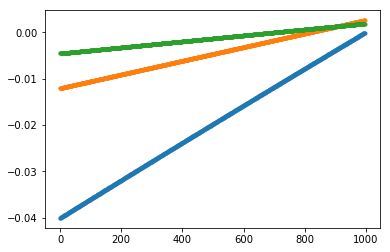

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(f1, '.')
plt.plot(f2, '.')
plt.plot(f3, '.')